In [223]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Which discount will save me the most money on Dutch train travel? #

In the Netherlands, the [OV-chipkaart](https://en.wikipedia.org/wiki/OV-chipkaart) is a card allowing travel on all forms of public transport. If you have a personal OV-chipkaart, you can buy a season ticket from NS (the main Dutch train operator) to get discounted train travel. 

But which season ticket is the best for me?

*Let's find out.*

### Which discounts are offered? ###


There are [6 season tickets that are currently offered](https://www.ns.nl/en/featured/traveling-with-discount/when-can-you-travel-with-a-discount.html). We will ignore the 'Kids Vrij' option allowing children aged 4-11 to join you for free, because it doesn't cost anything to use this discount and doesn't affect the ticket holder's fare.

Depending on the season ticket, there may be a full or partial discount for specific time periods:

* Peak travel hours (Weekdays 6:30-9:00, 16:00-18:30)
* Off-peak travel hours (all other times)
* Weekends
* Holidays

I manually made a table of the different discount offers. Here are the costs and benefits of a 2nd class travel:

In [109]:
discounts2 = pd.read_csv('discounts_2019_2nd_class.csv', index_col = 'discount_name')
discounts2

,peak_discount,off_peak_discount,weekend_discount,holiday_discount,monthly_price_per_month,yearly_price_per_month
discount_name,,,,,,
Altijd Voordeel,0.2,0.4,0.4,0.4,28.0,23.000000
Altijd Vrij,1.0,1.0,1.0,1.0,424.0,346.000000
Dal Voordeel,0.0,0.4,0.4,0.4,NaN,4.333333
Weekend Vrij,0.0,0.4,1.0,1.0,NaN,34.000000
Dal Vrij,0.0,1.0,1.0,1.0,NaN,105.000000
None,0.0,0.0,0.0,0.0,0.0,0.000000


Note that a season ticket can be purchased on a yearly basis, or in some cases on a monthly basis. When both options are available, it is cheaper per month to buy the yearly ticket (if you plan to use it all year). Prices in Euros.

There are similar discounts for 1st class travel, but in some cases the prices are higher. 

### How to access your travel history ###

Your personal travel history can be downloaded manually from the 'MijnNS' website. I chose to download the last year of data since some of the season tickets must be purchased on a yearly basis.

* This requires an ns.nl account with a personal OV chipkaart linked to it
* If you have this account, log into 'MijnNS' on the ns.nl website
* Select 'trein' from the 'Reishistorie' menu to display your travel history
* Select the desired date range and apply to see all trips in the desired time period
* At the bottom of the page, you can download the data as a pdf or csv file
* Save csv file.  I called mine 'reistransacties.csv'

*Note: If you want to also access your travel history for other forms of transport (buses, trams etc.), an account must be made on a different website. By paying an extra fee, you can also get discounted travel on these other forms of transport with a season ticket. This analysis will only focus on train travel.*

### Data cleaning ###

In [47]:
travel = pd.read_csv('reistransacties.csv')
travel.head()

,Datum,Check in,Vertrek,Check uit,Bestemming,Af,Bij,Transactie,Kl,Product,Prive/ Zakelijk,Opmerking
0,20-02-2018,NaN,NaN,NaN,NaN,"€0,00","€20,00",Saldo opladen,NaN,NaN,NaN,NaN
1,10-03-2018,NaN,NaN,NaN,NaN,"€0,00","€20,00",Saldo opladen,NaN,NaN,NaN,NaN
2,10-03-2018,11:29,Leiden Centraal,11:30,Leiden Centraal,"€0,00","€0,00",Reis,2.0,Dal Voordeel,NaN,NaN
3,11-03-2018,18:54,Leiden Centraal,18:55,Leiden Centraal,"€0,00","€0,00",Reis,2.0,Dal Voordeel,NaN,NaN
4,06-04-2018,09:17,Leiden Centraal,10:00,Amsterdam Centraal,"€5,50","€0,00",Reis,2.0,Dal Voordeel,NaN,NaN


Issues at first glance:

* Column names should be in English for consistency with rest of code
* The last 2 columns are not needed
* The rows recording times I topped up my balance ('Saldo opladen' transactions) are not needed
* Only check-in time matters for the fare, so checkout time can be removed
* Check-in times should be combined with dates and converted to datetime objects
* Fares should have the Euro sign removed and be converted to numbers
* Rows with fare of zero can be removed (I just passed through a station without travelling)

In [48]:
#Fix column names
cols_english = ['Date','Check_in_time', 'Origin', 'Checkout_time', 'Destination', 'Fare', 'Money_added', 
                'Transaction_type', 'Class','Discount_type', 'For_business', 'Notes']
travel.columns = cols_english


In [49]:
#Remove columns and rows that won't be used
travel = travel[travel['Transaction_type'] == 'Reis']
travel = travel.drop(columns=['Checkout_time','Transaction_type', 'Money_added', 'For_business', 'Notes'])

In [50]:
#Combine check-in date and time, convert to datetime
travel['Check_in_time'] = pd.to_datetime(travel['Date'] + ' ' + travel['Check_in_time'])
travel = travel.set_index('Check_in_time')
travel = travel.drop(columns=['Date'])

In [51]:
#Choose better data types for some columns
travel['Fare'] = travel['Fare'].apply(lambda x: float(x[1:].replace(',','.')))
travel['Class'] = travel['Class'].astype(int).astype('category')
travel['Discount_type'] = travel['Discount_type'].astype('category')

In [52]:
#Remove rows with fare of zero
travel = travel.loc[travel['Fare'] != 0.0]

Looks much better:

In [53]:
travel.head()

,Origin,Destination,Fare,Class,Discount_type
Check_in_time,,,,,
2018-06-04 09:17:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel
2018-06-04 11:57:00,Amsterdam Centraal,Leiden Centraal,5.5,2,Dal Voordeel
2018-08-04 07:34:00,Leiden Centraal,Rotterdam Centraal,4.4,2,Dal Voordeel
2018-08-04 14:25:00,Rotterdam Centraal,Leiden Centraal,4.4,2,Dal Voordeel
2018-04-19 11:55:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel


In [54]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 2018-06-04 09:17:00 to 2019-02-13 13:03:00
Data columns (total 5 columns):
Origin           88 non-null object
Destination      87 non-null object
Fare             88 non-null float64
Class            88 non-null category
Discount_type    88 non-null category
dtypes: category(2), float64(1), object(2)
memory usage: 3.1+ KB


It appears there was 1 journey where I forgot to check out based on a missing value in the destination column. Let's get some more details.

In [55]:
travel[travel['Destination'].isnull()]

,Origin,Destination,Fare,Class,Discount_type
Check_in_time,,,,,
2018-09-18 11:57:00,Leiden Centraal,NaN,10.0,2,Dal Voordeel


I happen to know that the destination was Amsterdam Centraal and the fare was €5.50. I got reimbursed later, so just to be correct let's fill in the correct values and estimate a checkout time.

In [56]:
#Check that there is only one trip on 2018-09-18
travel.loc['2018-09-18 11:57:00', 'Destination']

Check_in_time
2018-09-18 11:57:00    NaN
Name: Destination, dtype: object

In [57]:
#Adjust the values
travel.loc['2018-09-18 11:57:00', 'Destination'] = 'Amsterdam Centraal'
travel.loc['2018-09-18 11:57:00', 'Fare'] = 5.5

In [58]:
#Check that it all looks good
travel.loc['2018-09-18 11:57:00', :]

,Origin,Destination,Fare,Class,Discount_type
Check_in_time,,,,,
2018-09-18 11:57:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel


In [59]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88 entries, 2018-06-04 09:17:00 to 2019-02-13 13:03:00
Data columns (total 5 columns):
Origin           88 non-null object
Destination      88 non-null object
Fare             88 non-null float64
Class            88 non-null category
Discount_type    88 non-null category
dtypes: category(2), float64(1), object(2)
memory usage: 5.6+ KB


### Extra information to add ###

Some extra information will be needed in order to calculate the discounts from each season ticket. Columns to add:

* Columns indicating if each trip is peak/off-peak, on a weekend, or on a holiday
* The non-discounted fare for each trip. Because I had a Dal Voordeel season ticket for all of the trips, all off-peak trips got a 40% discount. 

In [60]:
#Day of week is integer from 0 to 6, 0 is for Monday
travel['weekend'] = travel.index.dayofweek > 4 

In [61]:
#Start & end of peak travel times
peakstart1 = pd.to_datetime('6:30').time()
peakend1 = pd.to_datetime('9:00').time()
peakstart2 = pd.to_datetime('16:00').time()
peakend2 = pd.to_datetime('18:30').time()

In [62]:
#Was check-in at peak?
travel['start1'] = travel.index.time > peakstart1
travel['end1'] = travel.index.time < peakend1 
travel['start2'] = travel.index.time > peakstart2 
travel['end2'] = travel.index.time < peakend2 
travel['peak'] = (travel['start1'] & travel['end1']) | (travel['start2'] & travel['end2'])
travel = travel.drop(columns = ['start1', 'end1', 'start2', 'end2'])

To find out if the trip was on a holiday, we need a list of holidays recognized by NS:

In [63]:
holidays = pd.read_csv('NL_holidays_20182019.csv')
holidays.head()

,Date,Holiday
0,2018-03-30,Good Friday
1,2018-04-01,Easter Sunday
2,2018-04-02,Easter Monday
3,2018-04-27,King’s Day
4,2018-05-10,Ascension Day


In [64]:
holidates = pd.to_datetime(holidays['Date']).dt.date.tolist()
holidates[0:5]

[datetime.date(2018, 3, 30),
 datetime.date(2018, 4, 1),
 datetime.date(2018, 4, 2),
 datetime.date(2018, 4, 27),
 datetime.date(2018, 5, 10)]

In [65]:
travel['Date'] = travel.index.date
travel['holiday'] = travel['Date'].isin(holidates)
travel = travel.drop(columns=['Date'])

In [66]:
travel.head()

,Origin,Destination,Fare,Class,Discount_type,weekend,peak,holiday
Check_in_time,,,,,,,,
2018-06-04 09:17:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel,False,False,False
2018-06-04 11:57:00,Amsterdam Centraal,Leiden Centraal,5.5,2,Dal Voordeel,False,False,False
2018-08-04 07:34:00,Leiden Centraal,Rotterdam Centraal,4.4,2,Dal Voordeel,True,True,False
2018-08-04 14:25:00,Rotterdam Centraal,Leiden Centraal,4.4,2,Dal Voordeel,True,False,False
2018-04-19 11:55:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel,False,False,False


If it is a weekend, holiday, or off-peak weekday then I received a 40% discount and the fare needs to be corrected to get its original value.

In [67]:
#Find if the discount was applied
travel['discount_used'] = travel.weekend | travel.holiday | ~travel.peak

In [68]:
def reverse_dal_voordeel(fare, used):
    '''Given a fare and a boolean indicating if the 
    Dal Voordeel discount was used, returns the original fare'''
    
    discount = 0.4
    if used:
        return round(fare / (1-discount),2)
    else:
        return fare

In [69]:
travel['true_fare'] = travel.apply(lambda x: reverse_dal_voordeel(x['Fare'], x['discount_used']), axis=1)
travel.head()

,Origin,Destination,Fare,Class,Discount_type,weekend,peak,holiday,discount_used,true_fare
Check_in_time,,,,,,,,,,
2018-06-04 09:17:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel,False,False,False,True,9.17
2018-06-04 11:57:00,Amsterdam Centraal,Leiden Centraal,5.5,2,Dal Voordeel,False,False,False,True,9.17
2018-08-04 07:34:00,Leiden Centraal,Rotterdam Centraal,4.4,2,Dal Voordeel,True,True,False,True,7.33
2018-08-04 14:25:00,Rotterdam Centraal,Leiden Centraal,4.4,2,Dal Voordeel,True,False,False,True,7.33
2018-04-19 11:55:00,Leiden Centraal,Amsterdam Centraal,5.5,2,Dal Voordeel,False,False,False,True,9.17


### Calculating the discount from different season tickets ###

Given the discount_name, class, true fare, and weekend/peak/holiday information, calculate:

* If the discount is applied
* What the discounted fare is

In [110]:
discounts2

,peak_discount,off_peak_discount,weekend_discount,holiday_discount,monthly_price_per_month,yearly_price_per_month
discount_name,,,,,,
Altijd Voordeel,0.2,0.4,0.4,0.4,28.0,23.000000
Altijd Vrij,1.0,1.0,1.0,1.0,424.0,346.000000
Dal Voordeel,0.0,0.4,0.4,0.4,NaN,4.333333
Weekend Vrij,0.0,0.4,1.0,1.0,NaN,34.000000
Dal Vrij,0.0,1.0,1.0,1.0,NaN,105.000000
None,0.0,0.0,0.0,0.0,0.0,0.000000


In [144]:
def get_discount_info(df, discount_name):
    '''Given: 
            * a dataframe of discount details with the
              discount names as the index
            * name of season ticket
            
    returns details of the discount in a dictionary'''
    
    details = df.loc[discount_name].copy()
    
    return({'peak_discount':details.loc['peak_discount'], 
            'off_peak_discount':details.loc['off_peak_discount'], 
            'weekend_discount':details.loc['weekend_discount'], 
            'holiday_discount':details.loc['holiday_discount']})

In [127]:
def get_discount_fraction(discount_dict, peak, weekend, holiday):
    '''Given a dictionary with discount info, and boolean
    values indicating if check-in was at peak, on a weekend, or
    on a holiday, returns a number between 0 and 1 indicating
    what fraction of the true fare should be discounted.'''
    
    if holiday:
        return discount_dict['holiday_discount']
    elif weekend:
        return discount_dict['weekend_discount']
    elif peak:
        return discount_dict['peak_discount']
    else:
        return discount_dict['off_peak_discount']

In [128]:
def apply_discount(fare, discount_fraction):
    return fare - fare * discount_fraction

In [148]:
def get_discounted_fare(df, discount_name, peak, weekend, holiday, true_fare):
    '''Given discount info dataframe, discount name, 
    booleans indicating if trip is at peak/weekend/holiday, and the
    full priced fare value, returns the discounted fare value for the 
    specified options'''
    
    disc_dict = get_discount_info(df, discount_name)
    discount_fraction = get_discount_fraction(disc_dict, peak, weekend, holiday)
    return(apply_discount(true_fare, discount_fraction))

In [141]:
t = travel[['weekend', 'peak', 'holiday', 'true_fare']]
t.head()

,weekend,peak,holiday,true_fare
Check_in_time,,,,
2018-06-04 09:17:00,False,False,False,9.17
2018-06-04 11:57:00,False,False,False,9.17
2018-08-04 07:34:00,True,True,False,7.33
2018-08-04 14:25:00,True,False,False,7.33
2018-04-19 11:55:00,False,False,False,9.17


In [142]:
disc_names = list(discounts2.index)

In [149]:
for n in disc_names:
    t[n] = t.apply(lambda x: get_discounted_fare(df = discounts2,
                                                 discount_name = n,
                                                 peak = x['peak'],
                                                 weekend = x['weekend'],
                                                 holiday = x['holiday'],
                                                 true_fare = x['true_fare']), 
                                                 axis=1)

In [150]:
t.head()

,weekend,peak,holiday,true_fare,Altijd Voordeel,Altijd Vrij,Dal Voordeel,Weekend Vrij,Dal Vrij,None
Check_in_time,,,,,,,,,,
2018-06-04 09:17:00,False,False,False,9.17,5.502,0.0,5.502,5.502,0.0,9.17
2018-06-04 11:57:00,False,False,False,9.17,5.502,0.0,5.502,5.502,0.0,9.17
2018-08-04 07:34:00,True,True,False,7.33,4.398,0.0,4.398,0.000,0.0,7.33
2018-08-04 14:25:00,True,False,False,7.33,4.398,0.0,4.398,0.000,0.0,7.33
2018-04-19 11:55:00,False,False,False,9.17,5.502,0.0,5.502,5.502,0.0,9.17


In [151]:
totals = t[disc_names]
totals.head()

,Altijd Voordeel,Altijd Vrij,Dal Voordeel,Weekend Vrij,Dal Vrij,None
Check_in_time,,,,,,
2018-06-04 09:17:00,5.502,0.0,5.502,5.502,0.0,9.17
2018-06-04 11:57:00,5.502,0.0,5.502,5.502,0.0,9.17
2018-08-04 07:34:00,4.398,0.0,4.398,0.000,0.0,7.33
2018-08-04 14:25:00,4.398,0.0,4.398,0.000,0.0,7.33
2018-04-19 11:55:00,5.502,0.0,5.502,5.502,0.0,9.17


In [157]:
yearly_fares = pd.DataFrame({'yearly_fares': round(totals.apply(sum), 2)})
yearly_fares

,yearly_fares
Altijd Voordeel,410.62
Altijd Vrij,0.00
Dal Voordeel,433.18
Weekend Vrij,317.42
Dal Vrij,112.80
None,646.76


In [158]:
subscription_costs = discounts2[['yearly_price_per_month']].copy()
subscription_costs['yearly_cost'] = round(subscription_costs['yearly_price_per_month'] * 12,2)
subscription_costs.head()

,yearly_price_per_month,yearly_cost
discount_name,,
Altijd Voordeel,23.000000,276.0
Altijd Vrij,346.000000,4152.0
Dal Voordeel,4.333333,52.0
Weekend Vrij,34.000000,408.0
Dal Vrij,105.000000,1260.0


In [166]:
total_costs = subscription_costs.join(yearly_fares, how = 'outer')
total_costs['yearly_total'] = total_costs['yearly_cost'] + total_costs['yearly_fares']
total_costs = total_costs.drop(columns = ['yearly_price_per_month'])
total_costs = total_costs.sort_values(by=['yearly_total'])
total_costs.head(6)

,yearly_cost,yearly_fares,yearly_total
discount_name,,,
Dal Voordeel,52.0,433.18,485.18
None,0.0,646.76,646.76
Altijd Voordeel,276.0,410.62,686.62
Weekend Vrij,408.0,317.42,725.42
Dal Vrij,1260.0,112.80,1372.80
Altijd Vrij,4152.0,0.00,4152.00


In [216]:
lowest_cost = total_costs['yearly_total'].min()
best_season_ticket = total_costs['yearly_total'].idxmin()
total_costs['diff'] = total_costs['yearly_total'] - lowest_cost
diff_low = round(total_costs['yearly_total'][1] - total_costs['yearly_total'][0], 2)
total_costs.head()

,yearly_cost,yearly_fares,yearly_total,diff
discount_name,,,,
Dal Voordeel,52.0,433.18,485.18,0.00
None,0.0,646.76,646.76,161.58
Altijd Voordeel,276.0,410.62,686.62,201.44
Weekend Vrij,408.0,317.42,725.42,240.24
Dal Vrij,1260.0,112.80,1372.80,887.62


In [222]:
print('The best season ticket based on the past year of travel history is the ' + best_season_ticket + '. And that is what I had!')
print('With this season ticket, the total cost is €' + str(lowest_cost) + '.' )
print('The ' + best_season_ticket + ' ticket saved €' + str(diff_low) + ' from the next cheapest ticket.')

The best season ticket based on the past year of travel history is the Dal Voordeel. And that is what I had!
With this season ticket, the total cost is €485.18.
The Dal Voordeel ticket saved €161.58 from the next cheapest ticket.


### Good news for me- I definitely had the best season ticket out of all the options! ###
Of course, it is quite likely that I modified my behavior to take advantage of the ticket that I had. But it's still nice to know that I did well.

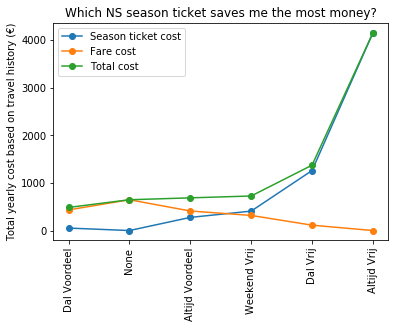

In [224]:
total_costs.iloc[:,0:3].plot(marker='o')
plt.xlabel('')
plt.ylabel('Total yearly cost based on travel history (€)')
plt.title('Which NS season ticket saves me the most money?')
plt.xticks([0, 1, 2, 3, 4, 5], list(total_costs.index), rotation = 'vertical')
plt.legend(labels=['Season ticket cost', 'Fare cost', 'Total cost'])
plt.show()

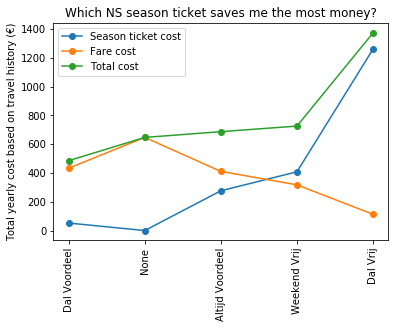

In [225]:
total_costs.iloc[:,0:3][total_costs['yearly_total'] < 2000].plot(marker='o')
plt.xlabel('')
plt.ylabel('Total yearly cost based on travel history (€)')
plt.title('Which NS season ticket saves me the most money?')
plt.xticks([0, 1, 2, 3, 4], list(total_costs.index[:-1]), rotation = 'vertical')
plt.legend(labels=['Season ticket cost', 'Fare cost', 'Total cost'])
plt.show()

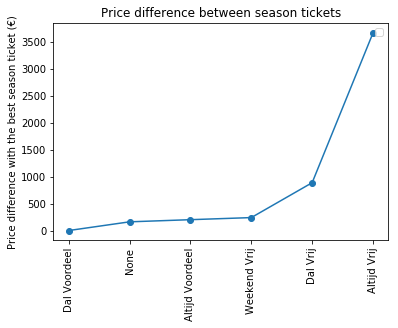

In [227]:
total_costs.iloc[:,3].plot(marker='o')
plt.xlabel('')
plt.ylabel('Price difference with the best season ticket (€)')
plt.title('Price difference between season tickets')
plt.xticks([0, 1, 2, 3, 4, 5], list(total_costs.index), rotation = 'vertical')
plt.legend(labels=[])
plt.show()